# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

* Compute the object and image points from the calibration chessboard images.

In [1]:
# Load modules.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0).
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space.
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images.
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    # Read in a calibration image.
    img = mpimg.imread(fname)
    # Convert calibration image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners for grayscale images.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points.
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners.
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('Chessboard',img)
        cv2.waitKey(500)
        
    '''
    # Save modified calibration images
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/' + img_name
    mpimg.imsave(new_path, img)
    '''

# Close all windows.
cv2.destroyAllWindows()

## Build an advanced lane line finding pipeline

* step 1 - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* step 2 - Apply a distortion correction to raw images.
* step 3 - Use color transforms, gradients, etc., to create a thresholded binary image.
* step 4 - Apply a perspective transform to rectify binary image ("birds-eye view").
* step 5 - Detect lane pixels and fit to find the lane boundary.
* step 6 - Determine the curvature of the lane and vehicle position with respect to center.
* step 7 - Warp the detected lane boundaries back onto the original image.
* step 8 - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Load modules

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### Helper functions

Define helper functions for further implementation of the pipeline.

In [3]:
# Function that performs a camera calibration, image distortion correction and returns an undistorted image.
def cal_undistort(img, objpoints, imgpoints):
    # Calculate camera calibration:
    # camera matrix 'mtx'
    # distortion coefficients 'dist'.
    # Position of camera in real world: rotation ('rvecs') and translation ('tvecs') vectors.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image.
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Function that computes the Sobel gradient in 'x' or 'y' direction, takes the absolute value and applies a threshold.
# sobel_kernel is an odd number >=3.
# thresh runs from 0 to 255.
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Convert image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value.
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer.
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result.
    return grad_binary

# Function that computes the magnitude of the Sobel gradients and applies a threshold.
# sobel_kernel is an odd number >=3.
# thresh runs from 0 to 255.
def mag_thresh(img, sobel_kernel, mag_thresh):
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients.
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude.
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit.
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise.
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image.
    return mag_binary

# Function that computes the direction of the Sobel gradients and applies a threshold.
# sobel_kernel is an odd number >=3.
# thresh runs from 0 to pi/2.
def dir_threshold(img, sobel_kernel, thresh):
    # Grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients.
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result.
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image.
    return dir_binary
                        
# Function that explores RGB colour space.
def rgb_threshold(img, thresh, channel):
    # Define channel:
    # R = 0, G = 1 & B = 2.
    colour = img[:,:,channel]
    # Create a binary mask where thresholds are met.
    binary = np.zeros_like(colour)
    binary[(colour > thresh[0]) & (colour <= thresh[1])] = 1
    # Return the binary image.
    return binary

# Function that explores HLS colour space.
def hls_threshold(img, thresh, channel):
    # Convert to HLS colour space.
    # H = 0, L = 1 & S = 2.
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    colour = hls[:,:,channel]
    # Create a binary mask where thresholds are met.
    binary = np.zeros_like(colour)
    binary[(colour > thresh[0]) & (colour <= thresh[1])] = 1
    # Return the binary image.
    return binary

# Function that performs a perspective transform of an image.
def warper(img, src, dst):
    # Get size of image.
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    # Apply the perspective transform.
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    # Return the warped image.
    return warped

### Pipeline (single images)

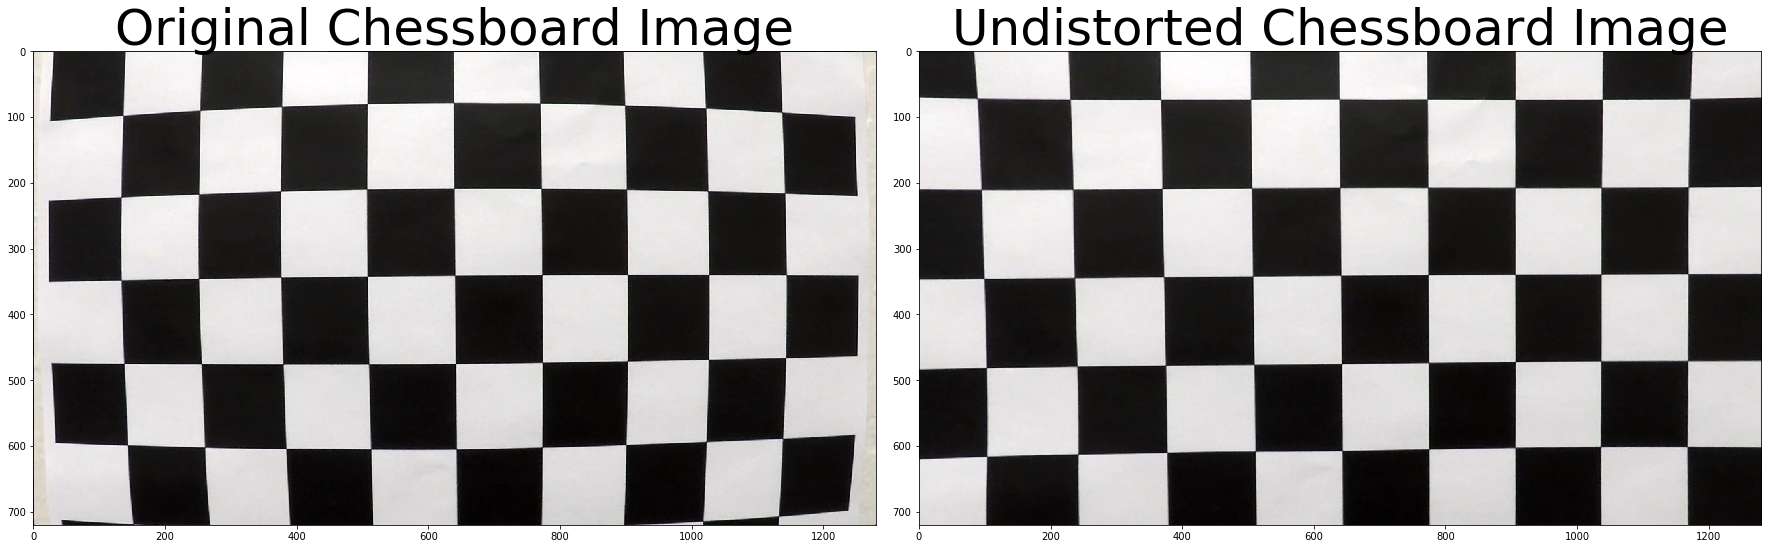

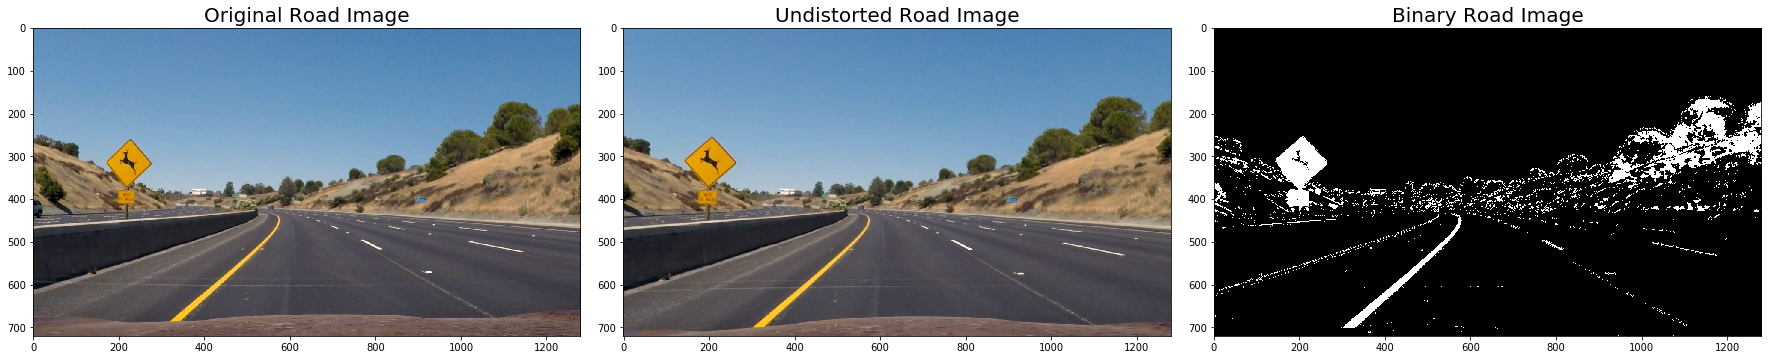

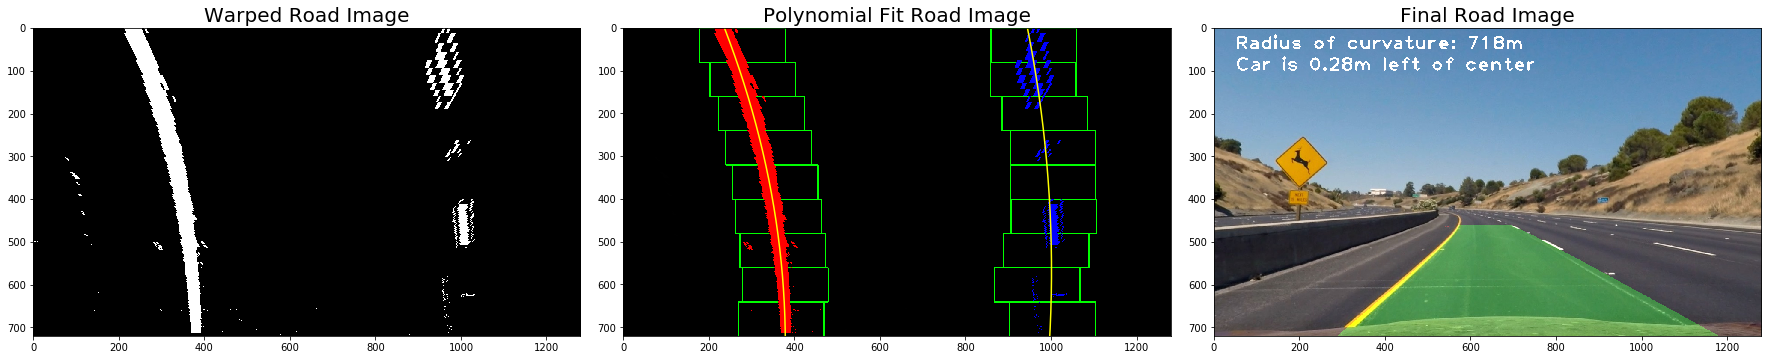

In [4]:
%matplotlib inline

# Choose a Sobel kernel size.
ksize = 15 # Choose a larger odd number to smooth gradient measurements.

# Choose source and destination points for perspective transform.
src = np.float32([[585, 460],[695, 460],[203, 720],[1127, 720]])
dst = np.float32([[320,0],[960,0],[320,720],[960,720]])

# Make a list of the road images.
images = glob.glob('./test_images/*.jpg')

# Step through all road images.
for fname in images:
    #print(fname)
    
    # Read in a road image.
    img = mpimg.imread(fname)
    
    # STEP 1 & 2 - DISTORTION CORRECTION.  
    # Undistort all road images and save them.
    # Undistort road image.
    undistorted = cal_undistort(img, objpoints, imgpoints)

    '''
    # Save undistorted road images.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/undistorted_' + img_name
    #print(new_path)
    mpimg.imsave(new_path, undistorted)
    '''
    
    # STEP 3 - THRESHOLDS.
    # Apply thresholding mask to all road images and save them.
    # Apply each of the thresholding functions.
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    r_channel = rgb_threshold(undistorted, thresh=(200,255), channel=0)
    g_channel = rgb_threshold(undistorted, thresh=(200,255), channel=1)
    h_channel = hls_threshold(undistorted, thresh=(15,100), channel=0)
    s_channel = hls_threshold(undistorted, thresh=(90,255), channel=2)

    # Combine thresholding functions appropriately.
    combined = np.zeros_like(s_channel)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((r_channel == 1) & (g_channel == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1))] = 1
    combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((gradx == 1) & (grady == 1))] = 1
    #combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    '''
    # Save binary road images.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/binary_' + img_name
    mpimg.imsave(new_path, combined, cmap='gray')
    '''

    # STEP 4 - PERSPECTIVE TRANSFORM.
    # Apply a perspective transform to all road images and save them.
    warped_img = warper(combined, src, dst)
    # Rescale back to 8 bit integer.
    binary_warped = np.uint8(255*warped_img/np.max(warped_img))
    
    '''
    # Save warped road images.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/warped_' + img_name
    mpimg.imsave(new_path, binary_warped, cmap='gray')
    '''
    
    # STEP 5 - LANE PIXELS DETECTION.
    # Take a histogram of the bottom half of the image.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result.
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram.
    # These will be the starting point for the left and right lines.
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows.
    nwindows = 9
    # Set height of windows.
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image.
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window.
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin.
    margin = 100
    # Set minimum number of pixels found to recenter window.
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices.
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one.
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left).
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image.
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window.
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists.
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position.
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices.
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions.
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each.
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting.
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    '''
    # Plot the polynomial fit on road images.
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    fig = plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    # Save road images with polynomial fit.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/polyfit_' + img_name
    fig.savefig(new_path)
    plt.close(fig)
    '''
    
    # STEP 6 - RADIUS OF CURVATURE.
    # Measure the radius of curvature (in pixel space) closest to the vehicle.
    y_eval = np.max(ploty)
    #print(y_eval)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)

    # Measure the radius of curvature (in real world space (meters)) closest to the vehicle. 
    # Define conversions in x and y from pixels space to meters.
    ym_per_pix = 30/720 # meters per pixel in y dimension.
    xm_per_pix = 3.7/640 # meters per pixel in x dimension.

    # Fit new polynomials to x,y in world space.
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature.
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters.
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Final radius of curvature.
    curverad = (left_curverad + right_curverad) / 2
    #print(curverad)
    
    # STEP 6 - POSITION OF CAR.
    # Calculate the center of the road image in pixels.
    img_center = img.shape[1]/2
    #print('Image Center: ', img_center)
    # Calculate the center of the lane center in pixels.
    left_point = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    #print('Left point: ', left_point)
    right_point = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    #print('Right point: ', right_point)
    lane_center = (right_point + left_point) / 2
    #print('Lane center: ', lane_center)
    # Calculate the offset in pixels.
    offset = img_center - lane_center
    #print('Offset: ', offset)
    # Convert to meters.
    offset_final = offset * xm_per_pix
    #print('Final offset: ', offset_final, 'm')
   
    # STEP 7 - ROJECT LANE LINES BACK ON ORIGINAL ROAD IMAGE.
    # Create an image to draw the lines on.
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly().
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image.
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.putText(img=color_warp, text='Test', org=(100,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=255)

    # Warp the blank back to original image space using inverse perspective matrix.
    newwarp = warper(color_warp, dst, src)
    # STEP 8
    # Combine the result with the original image.
    final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    # Write the radius of curvature into the road image.
    final = cv2.putText(img=final, text='Radius of curvature: '+str(int(curverad))+'m', org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    # Write the offset into the road image.
    # Define the text.
    if offset_final > 0:
        final = cv2.putText(img=final, text='Car is '+str(round(abs(offset_final),2))+'m right of center', org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    if offset_final < 0:
        final = cv2.putText(img=final, text='Car is '+str(round(abs(offset_final),2))+'m left of center', org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    if offset_final == 0:
        final = cv2.putText(img=final, text='Car is in center', org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    
    '''
    # Save final road images.
    path = str(fname)
    filename = path.split('/')[-1]
    img_name = filename.split('.')[-2]
    new_path = './output_images/final_' + img_name
    mpimg.imsave(new_path, final)
    '''
    
    
    
# VISUALIZATION.
# Undistort, plot and save a chessboard image for reference.
# Read in a chessboard image.
img_chess = mpimg.imread('./camera_cal/calibration1.jpg')
# Undistort chessboard image.
undistorted_chess = cal_undistort(img_chess, objpoints, imgpoints)
# Plot undistorted chessboard image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_chess)
ax1.set_title('Original Chessboard Image', fontsize=50)
ax2.imshow(undistorted_chess)
ax2.set_title('Undistorted Chessboard Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''
# Save undistorted road image.
path = './output_images/undistorted_chessboard'
mpimg.imsave(path, undistorted)
'''
   
# Plot example image of original, undistorted and binary road image.
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Road Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Road Image', fontsize=20)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Binary Road Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax4.imshow(warped_img, cmap='gray')
ax4.set_title('Warped Road Image', fontsize=20)

# Plot example image of warped road image, polynomial fit on road image and final road image.
# Generate x and y values for plotting.
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
ax5.imshow(out_img)
ax5.plot(left_fitx, ploty, color='yellow')
ax5.plot(right_fitx, ploty, color='yellow')
ax5.set_xlim(0, 1280)
ax5.set_ylim(720, 0)
ax5.set_title('Polynomial Fit Road Image', fontsize=20)
ax6.imshow(final)
ax6.set_title('Final Road Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Print radius of curvature for example road image.
#print('Left radius of curvature:', left_curverad, 'm')
#print('Right radius of curvature:', right_curverad, 'm')
#print('Final radius of curvature:', curverad, 'm')

## Run on videos

In order to run the cells in this section you first need to run:

* the cell in the section: Camera calibration using chessboard images
* the cell in the section: Build an advanced lane line finding pipeline - Helper functions

In [38]:
# Import everything needed to edit/save/watch video clips.
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
def process_image(img, objpoints, imgpoints, ksize, src, dst):
    # DISTORTION CORRECTION.  
    # Undistort road image.
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    # THRESHOLDS.
    # Apply thresholding mask to road image.
    # Apply each of the thresholding functions.
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    r_channel = rgb_threshold(undistorted, thresh=(200,255), channel=0)
    g_channel = rgb_threshold(undistorted, thresh=(200,255), channel=1)
    h_channel = hls_threshold(undistorted, thresh=(15,100), channel=0)
    s_channel = hls_threshold(undistorted, thresh=(90,255), channel=2)

    # Combine thresholding functions appropriately.
    combined = np.zeros_like(s_channel)
    combined[((h_channel == 1) & (s_channel == 1)) | ((r_channel == 1) & (g_channel == 1)) | ((gradx == 1) & (grady == 1))] = 1
    
    # PERSPECTIVE TRANSFORM.
    # Apply a perspective transform to road image.
    warped_img = warper(combined, src, dst)
    # Rescale back to 8 bit integer.
    binary_warped = np.uint8(255*warped_img/np.max(warped_img))
    
    # LANE PIXELS DETECTION.
    # Take a histogram of the bottom half of the image.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result.
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram.
    # These will be the starting point for the left and right lines.
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows.
    nwindows = 9
    # Set height of windows.
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image.
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window.
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin.
    margin = 100
    # Set minimum number of pixels found to recenter window.
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices.
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one.
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left).
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image.
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window.
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists.
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position.
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices.
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions.
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each.
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting.
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # RADIUS OF CURVATURE.
    # Measure the radius of curvature (in real world space (meters)) closest to the vehicle. 
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters.
    ym_per_pix = 30/720 # meters per pixel in y dimension.
    xm_per_pix = 3.7/640 # meters per pixel in x dimension.

    # Fit new polynomials to x,y in world space.
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature.
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters.
    
    # Final radius of curvature.
    curverad = (left_curverad + right_curverad) / 2
    
    # POSITION OF CAR.
    # Calculate the center of the road image in pixels.
    img_center = img.shape[1]/2
    # Calculate the center of the lane center in pixels.
    left_point = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_point = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (right_point + left_point) / 2
    # Calculate the offset in pixels.
    offset = img_center - lane_center
    # Convert to meters.
    offset_final = offset * xm_per_pix
    
    # PROJECT LANE LINES BACK ON ORIGINAL ROAD IMAGE.
    # Create an image to draw the lines on.
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly().
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image.
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv).
    newwarp = warper(color_warp, dst, src)
    # Combine the result with the original image.
    final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    # Write the radius of curvature into the image.
    final = cv2.putText(img=final, text='Radius of curvature: '+str(int(curverad))+'m', org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    # Write the offset into the image.
    # Define the text.
    if offset_final > 0:
        final = cv2.putText(img=final, text='Car is '+str(round(abs(offset_final),2))+'m right of center', org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    if offset_final < 0:
        final = cv2.putText(img=final, text='Car is '+str(round(abs(offset_final),2))+'m left of center', org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    if offset_final == 0:
        final = cv2.putText(img=final, text='Car is in center', org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness=3)
    
    return final

def process_clip(clip, objpoints, imgpoints, ksize, src, dst):
    def process_help(image):
        return process_image(image, objpoints, imgpoints, ksize, src, dst)
    return clip.fl_image(process_help)

Define parameters of the pipeline.

In [40]:
# Choose a Sobel kernel size.
ksize = 15 # Choose a larger odd number to smooth gradient measurements.

# Choose source and destination points for perspective transform.
src = np.float32([[585, 460],[695, 460],[203, 720],[1127, 720]])
dst = np.float32([[320,0],[960,0],[320,720],[960,720]])

Run pipeline on project video.

In [43]:
video_output = './final_project_video.mp4'
clip = VideoFileClip("./project_video.mp4")
video_clip = clip.fx(process_clip, objpoints, imgpoints, ksize, src, dst)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./final_project_video.mp4
[MoviePy] Writing video ./final_project_video.mp4


100%|█████████▉| 1260/1261 [34:43<00:01,  1.67s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./final_project_video.mp4 

CPU times: user 36min 9s, sys: 2.76 s, total: 36min 12s
Wall time: 34min 44s


Display final project video.

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))


---
## Appendix A: Perspective transform

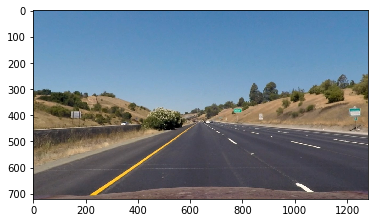

In [11]:
# Load modules.
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Load road image with straight lane lines.
img_pt = mpimg.imread('./test_images/straight_lines1.jpg')

# Undistort and display the road image with straight lane lines.
undist_pt = cal_undistort(img_pt, objpoints, imgpoints)
plt.imshow(undist_pt)

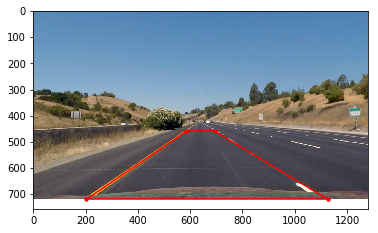

In [12]:
%matplotlib inline

# Plot undistorted road image (with straight lane lines) together with the source points.
plt.imshow(undist_pt)
x1, y1 = [585, 695], [460, 460] # top: left -> right
x2, y2 = [695, 1127], [460, 720] # right: top -> bottom,
x3, y3 = [1127, 203], [720, 720] # bottom : right-> left
x4, y4 = [585, 203], [460, 720] # left: top -> bottom
plt.plot(x1, y1, x2, y2, x3, y3, x4, y4, marker = '.', color = 'red') 

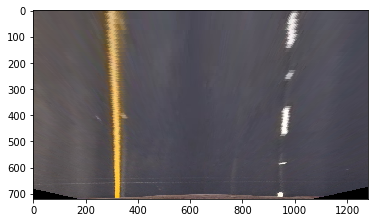

In [14]:
# Choose source and destination points for perspective transform.
offset = 0
src = np.float32([[585, 460],[695, 460],[203, 720],[1127, 720]])
dst = np.float32([[320,0],[960,0],[320,720],[960,720]])

# Apply a perspective transform to the undistorted road image with straight lane lines.
warped_pt = warper(undist_pt, src, dst)

# Plot warped road image with straight lane lines.
plt.imshow(warped_pt)

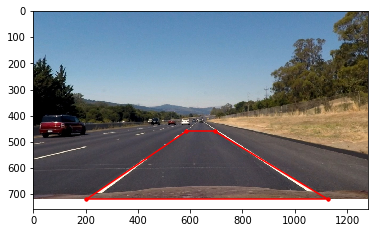

In [15]:
%matplotlib inline

# Test the source points on a second road image with straight lane lines.
# Load a second road image with straight lane lines and undistort it.
img_pt = mpimg.imread('./test_images/straight_lines2.jpg')
undist_pt = cal_undistort(img_pt, objpoints, imgpoints)

# Plot the second undistorted road image (with straight lane lines) together with the source points for reference.
plt.imshow(undist_pt)
x1, y1 = [585, 695], [460, 460] # top: left -> right
x2, y2 = [695, 1127], [460, 720] # right: top -> bottom,
x3, y3 = [1127, 203], [720, 720] # bottom : right-> left
x4, y4 = [585, 203], [460, 720] # left: top -> bottom
plt.plot(x1, y1, x2, y2, x3, y3, x4, y4, marker = '.', color = 'red') 

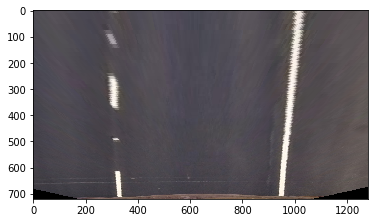

In [16]:
# Apply a perspective transform to the second undistorted road image with straight lane lines.
warped_pt = warper(undist_pt, src, dst)

# Plot second warped road image with straight lane lines for reference.
plt.imshow(warped_pt)